In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten ,Dropout
import tensorflow as tf
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score, roc_curve, auc ,accuracy_score,precision_score,recall_score,f1_score,accuracy_score

In [2]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

num_train = 49000

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


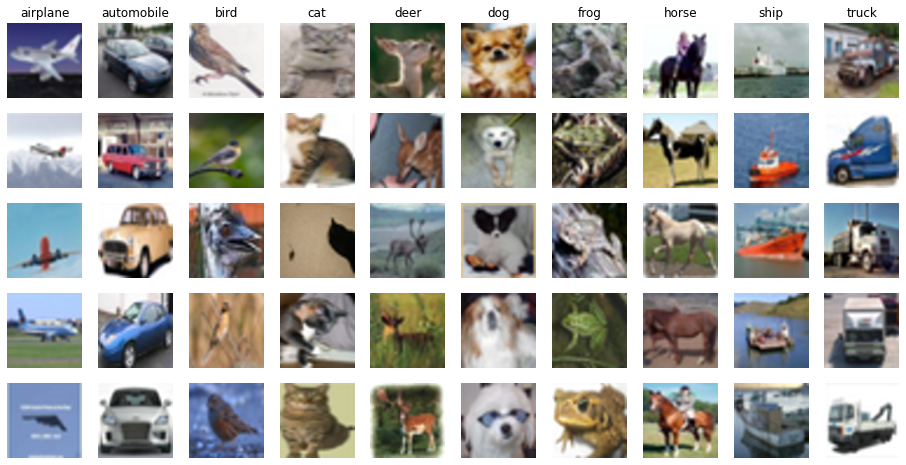

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

In [5]:
# convert pixel range from [0, 255] to [0., 1.]
#X_test = datagen.standardize(X_test)
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

X_train /= 255.0

mu = np.mean(X_train, axis=0)
ms = np.std(X_train, axis=0)
X_train =(X_train-mu)/ms



x_test /= 255.0
x_test =(x_test-mu)/ms



print(X_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]
for i in range(3):
    X_train[:, i, :, :] = X_train[:, i, :, :] - mean[i]
    X_train[:, i, :, :] = X_train[:, i, :, :] / std[i]
    x_test[:, i, :, :] = X_test[:, i, :, :] - mean[i]
    X_test[:, i, :, :] = X_test[:, i, :, :] / std[i]

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [7]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [8]:
def create_cnn():
    model = Sequential()
    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same' , strides=(1, 1), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization(momentum=0.05,trainable=True, epsilon=1e-05))# affine=True, track_running_stats=True
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1),))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))          


    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 4
    model.add(Conv2D(512, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 5
    model.add(Conv2D(2048, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 6
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)


    # Classifier
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       1

In [9]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

step = tf.Variable(0, trainable=False)
boundaries = [20*STEPS_PER_EPOCH,40*STEPS_PER_EPOCH,88*STEPS_PER_EPOCH]
values = [0.1, 0.01 , 0.001, 0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
def augment(X_train):
  image = tf.image.random_flip_left_right(image,seed=None)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return X_train

In [12]:
weight_decay= 0.002

In [13]:
# a utility function to add weight decay after the model is defined.
def add_weight_decay(model, weight_decay):
    if (weight_decay is None) or (weight_decay == 0.0):
        return

    # recursion inside the model
    def add_decay_loss(m, factor):
        if isinstance(m, tf.keras.Model):
            for layer in m.layers:
                add_decay_loss(layer, factor)
        else:
            for param in m.trainable_weights:
                with tf.keras.backend.name_scope('weight_regularizer'):
                    regularizer = lambda: tf.keras.regularizers.l2(factor)(param)
                    m.add_loss(regularizer)

    # weight decay and l2 regularization differs by a factor of 2
    add_decay_loss(model, weight_decay/2.0)
    return

In [14]:
history =model.fit(X_train[:num_train], y_train[:num_train],batch_size=64,epochs=10,validation_data=(X_train[num_train:], y_train[num_train:]))

Epoch 1/10
766/766 [==============================] - 40s 52ms/step - loss: 1.4074 - accuracy: 0.4908 - val_loss: 1.4321 - val_accuracy: 0.5340
Epoch 2/10
766/766 [==============================] - 39s 51ms/step - loss: 0.8291 - accuracy: 0.7062 - val_loss: 0.8000 - val_accuracy: 0.7340
Epoch 3/10
766/766 [==============================] - 39s 51ms/step - loss: 0.6239 - accuracy: 0.7834 - val_loss: 0.6553 - val_accuracy: 0.7940
Epoch 4/10
766/766 [==============================] - 39s 51ms/step - loss: 0.5037 - accuracy: 0.8258 - val_loss: 0.5658 - val_accuracy: 0.8140
Epoch 5/10
766/766 [==============================] - 39s 51ms/step - loss: 0.4212 - accuracy: 0.8559 - val_loss: 0.4706 - val_accuracy: 0.8480
Epoch 6/10
766/766 [==============================] - 39s 51ms/step - loss: 0.3529 - accuracy: 0.8769 - val_loss: 0.5632 - val_accuracy: 0.8160
Epoch 7/10
766/766 [==============================] - 39s 51ms/step - loss: 0.3025 - accuracy: 0.8956 - val_loss: 0.6058 - val_accuracy:

In [28]:
model.save('cifar10.simplenet.auc90.35.h5')
                 
#model=load_model('cifar10_01.h5')

In [15]:
y_pred = model.predict(x_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round())))  

Auc = 0.909178
f1_score = 0.844577
precision = 0.866530
recall  = 0.833700
accuracy  = 0.833700


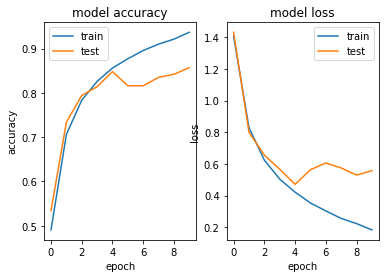

In [16]:
plothist(history)